# Chapter 3: Modelling and Evaluation - Analyse

In [2]:
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence


from pygam import LinearGAM, s, l
from pygam.datasets import wage


import seaborn as sns
import matplotlib.pyplot as plt

from dmba import stepwise_selection
from dmba import AIC_score

In [3]:
%matplotlib inline

# Simple Linear Regression
## The Regression Equation

     Adj Close  FEDFUNDS
0    16.750000      0.12
1    16.855000      0.12
2    18.010000      0.12
3    17.940001      0.11
4    18.370001      0.13
..         ...       ...
158  68.477997      4.10
159  71.818001      4.33
160  72.244003      4.57
161  72.377998      4.65
162  72.566002      4.83

[163 rows x 2 columns]
Intercept: -0.485
Coefficient Exposure: 0.029


C:\Users\hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


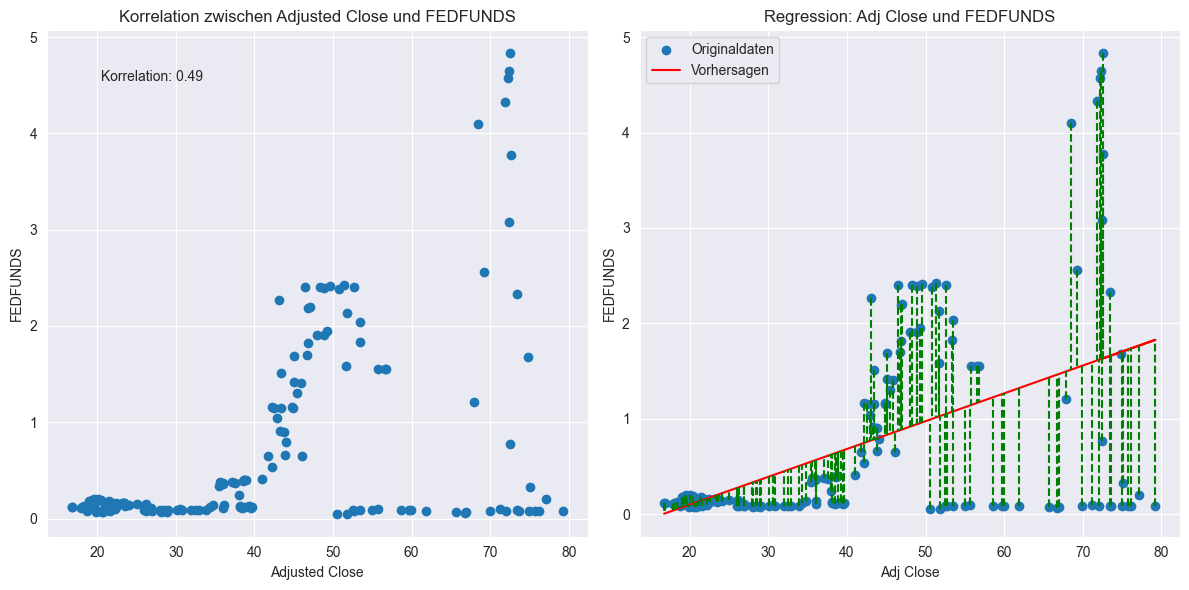

In [4]:
# Daten einlesen
etf_monthly = pd.read_csv('data/iShares Core MSCI World UCITS ETF USD (Acc)_Monthly.csv')
fed_funds = pd.read_csv('data/Leitzins_USA_FED_Banken.csv')

# Daten filtern und kombinieren
etf_filtered = etf_monthly.loc[(etf_monthly['Date'] >= '2009-10-01') & (etf_monthly['Date'] <= '2023-06-01'), ['Adj Close']]
fed_funds_filtered = fed_funds.loc[(fed_funds['DATE'] >= '2009-10-01') & (fed_funds['DATE'] <= '2023-06-01'), ['FEDFUNDS']]

# Daten zusammenführen
# reset_index()-Funktion setzt Index des Datenrahmens zurücksetzt
etf_fed_funds_combined_data = pd.concat([etf_filtered.reset_index(drop=True), fed_funds_filtered.reset_index(drop=True)], axis=1)

# print(len(etf_filtered))
# print(len(fed_funds_filtered))
# # Überprüfen der Datenlängen
# if len(etf_filtered) != len(fed_funds_filtered):
#     raise ValueError("Die Datenlängen stimmen nicht überein.")

# Korrelation berechnen
correlation = etf_fed_funds_combined_data.corr().iloc[0, 1]
# print(correlation)
etf_fed_funds_combined_data.dropna(inplace=True)
#etf_fed_funds_combined_data.fillna(etf_fed_funds_combined_data.mean(), inplace=True)
etf_fed_funds_combined_data.interpolate(inplace=True)

print(etf_fed_funds_combined_data)

#----------------------------------------------------------------------------------------

model = LinearRegression()

# Reshape der Eingabe in die 2D-Array-Form
X = etf_fed_funds_combined_data['Adj Close'].values.reshape(-1, 1)
y = etf_fed_funds_combined_data['FEDFUNDS'].values.reshape(-1, 1)
model.fit(X, y)

fitted = model.predict(X)
residuals = y - fitted

print(f'Intercept: {model.intercept_[0]:.3f}')
print(f'Coefficient Exposure: {model.coef_[0][0]:.3f}')

# Vorhersagen und Residuen berechnen
fitted = model.predict(X)
residuals = y - fitted

# Figure und Subplots erstellen
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Scatterplot der Korrelation
ax1.scatter(etf_fed_funds_combined_data['Adj Close'], etf_fed_funds_combined_data['FEDFUNDS'])
ax1.set_xlabel('Adjusted Close')
ax1.set_ylabel('FEDFUNDS')
ax1.set_title('Korrelation zwischen Adjusted Close und FEDFUNDS')
ax1.text(0.1, 0.9, f'Korrelation: {correlation:.2f}', transform=ax1.transAxes)

# Scatterplot und Linienplot der Regression
ax2.scatter(etf_fed_funds_combined_data['Adj Close'], etf_fed_funds_combined_data['FEDFUNDS'], label='Originaldaten')
ax2.plot(etf_fed_funds_combined_data['Adj Close'], fitted, color='red', label='Vorhersagen')

# Residuenlinien zeichnen
for x, y_actual, y_fitted in zip(etf_fed_funds_combined_data['Adj Close'], etf_fed_funds_combined_data['FEDFUNDS'], fitted):
    ax2.plot([x, x], [y_actual, y_fitted], '--', color='green')

ax2.set_xlabel('Adj Close')
ax2.set_ylabel('FEDFUNDS')
ax2.set_title('Regression: Adj Close und FEDFUNDS')
ax2.legend()

# Diagramme anzeigen
plt.tight_layout()
plt.show()


# Multiple linear regression

C:\Users\hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Text(0.5, 1.0, 'Regression: Adj Close und FEDFUNDS mit Gewichtung')

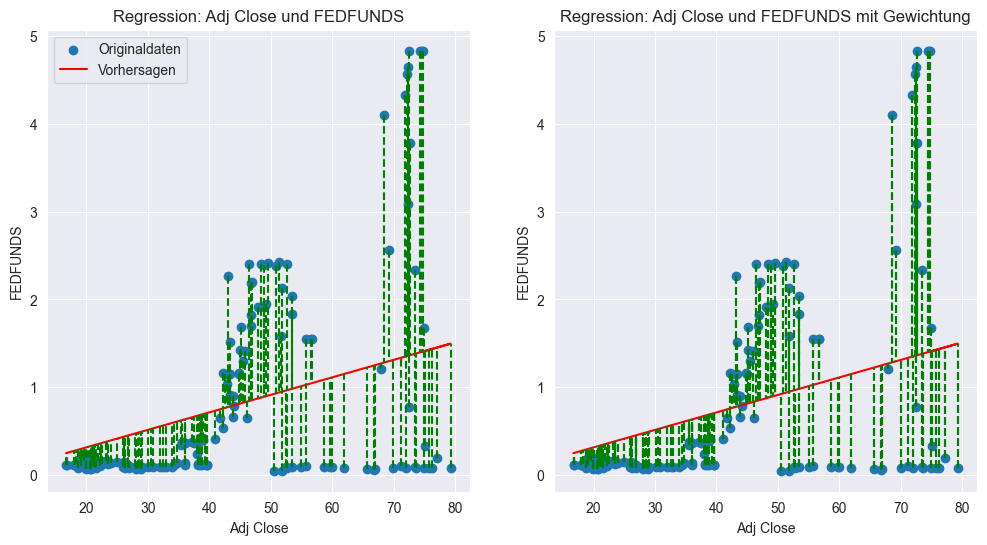

In [5]:
# TODO: Überarbeitung notwendig, kein Unterschied zwischen Gewichtung und keine Gewichtung
etf_monthly = pd.read_csv('data/iShares Core MSCI World UCITS ETF USD (Acc)_Monthly.csv')
fed_funds = pd.read_csv('data/Leitzins_USA_FED_Banken.csv')

etf_filtered = etf_monthly.loc[(etf_monthly['Date'] >= '2009-10-01') & (etf_monthly['Date'] <= '2023-06-01'), ['Adj Close', 'Volume']]
fed_funds_filtered = fed_funds.loc[(fed_funds['DATE'] >= '2009-10-01') & (fed_funds['DATE'] <= '2023-06-01'), ['FEDFUNDS']]

# Daten zusammenführen und fehlende Werte interpolieren
etf_fed_funds_combined_data = pd.concat([etf_filtered.reset_index(drop=True), fed_funds_filtered.reset_index(drop=True)], axis=1)
etf_fed_funds_combined_data.interpolate(inplace=True)


#------------------------------------------------------------------------------------

# Gewichtung basierend auf dem Volumen
weights = etf_fed_funds_combined_data['Volume']

# Lineare Regression mit gewichteten Daten durchführen
model = LinearRegression()
model.fit(etf_fed_funds_combined_data['Adj Close'].values.reshape(-1, 1), etf_fed_funds_combined_data['FEDFUNDS'].values.reshape(-1, 1), sample_weight=weights)

# Vorhersagen und Residuen berechnen
fitted = model.predict(etf_fed_funds_combined_data['Adj Close'].values.reshape(-1, 1))
residuals = etf_fed_funds_combined_data['FEDFUNDS'] - fitted.flatten()

# Figure und Subplots erstellen
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Scatterplot und Linienplot der Regression
ax1.scatter(etf_fed_funds_combined_data['Adj Close'], etf_fed_funds_combined_data['FEDFUNDS'], label='Originaldaten')
ax1.plot(etf_fed_funds_combined_data['Adj Close'], fitted, color='red', label='Vorhersagen')


#------------------------------------------------------------------------------------
# Residuenlinien zeichnen
for x, y_actual, y_fitted in zip(etf_fed_funds_combined_data['Adj Close'], etf_fed_funds_combined_data['FEDFUNDS'], fitted):
    ax1.plot([x, x], [y_actual, y_fitted], '--', color='green')

for x, y_actual, y_fitted in zip(etf_fed_funds_combined_data['Adj Close'], etf_fed_funds_combined_data['FEDFUNDS'], fitted):
    ax2.plot([x, x], [y_actual, y_fitted], '--', color='green')

ax1.set_xlabel('Adj Close')
ax1.set_ylabel('FEDFUNDS')
ax1.set_title('Regression: Adj Close und FEDFUNDS')
ax1.legend()

#------------------------------------------------------------------------------------

# Scatterplot und Linienplot der gewichteten Regression
ax2.scatter(etf_fed_funds_combined_data['Adj Close'], etf_fed_funds_combined_data['FEDFUNDS'], label='Originaldaten')
ax2.plot(etf_fed_funds_combined_data['Adj Close'], fitted, color='red', label='Vorhersagen (gewichtet)')

# Residuenlinien zeichnen
for x, y_actual, y_fitted in zip(etf_fed_funds_combined_data['Adj Close'], etf_fed_funds_combined_data['FEDFUNDS'], fitted.flatten()):
    ax2.plot([x, x], [y_actual, y_fitted], '--', color='green')

ax2.set_xlabel('Adj Close')
ax2.set_ylabel('FEDFUNDS')
ax2.set_title('Regression: Adj Close und FEDFUNDS mit Gewichtung')


In [6]:
# Daten aus der CSV-Datei laden
leitzins_df = pd.read_csv('data/leitzins Europa.csv')

# Spalten "Obs. Status" und "Obs. Comment" entfernen
leitzins_df = leitzins_df.drop(['obs. status', 'obs. comment'], axis=1)

# Umwandeln des Datums in das Datumsformat
leitzins_df['Date'] = pd.to_datetime(leitzins_df['Date'])

# Filtern der Daten nach dem gewünschten Zeitraum
leitzins_filtered = leitzins_df[(leitzins_df['Date'] >= '1999-01-01') & (leitzins_df['Date'] <= '2023-04-22')]

# Extrahieren von Monat und Jahr aus dem Datum
leitzins_filtered['Monat'] = leitzins_filtered['Date'].dt.month
leitzins_filtered['Jahr'] = leitzins_filtered['Date'].dt.year

# Gruppieren nach Jahr und Monat und Berechnung des Durchschnitts
monatliche_leitzins_df = leitzins_filtered.groupby(['Jahr', 'Monat']).mean()

# Speichern der monatlichen Leitzinswerte in eine neue CSV-Datei
monatliche_leitzins_df.to_csv('data/generatedDatasets/monatliche_leitzins_ezb.csv', index=False)

In [7]:
# CSV-Datei einlesen
fed_funds_customer_monthly = pd.read_csv('data/Leitzins_USA_FED_Kunden.csv')

# Spalte 'DATE' in ein DateTime-Format konvertieren
fed_funds_customer_monthly['DATE'] = pd.to_datetime(fed_funds_customer_monthly['DATE'])

# DataFrame-Index auf 'DATE' setzen
fed_funds_customer_monthly.set_index('DATE', inplace=True)

# Datenreihe resamplen und fehlende Monate auffüllen
fed_funds_customer_monthly = fed_funds_customer_monthly.resample('MS').ffill()

# DataFrame-Index zurücksetzen
fed_funds_customer_monthly = fed_funds_customer_monthly.reset_index()

# CSV-Datei mit aufgefüllten Monaten speichern
fed_funds_customer_monthly.to_csv('data/generatedDatasets/Leitzins_USA_FED_Kunden_aufgefuellt.csv', index=False)

In [8]:
# Auslesen der einzelnen Daten in einer Tabelle

etf_monthly = pd.read_csv('data/iShares Core MSCI World UCITS ETF USD (Acc)_Monthly.csv')
fed_funds_banks_monthly = pd.read_csv('data/Leitzins_USA_FED_Banken.csv')
eu_funds_monthly = pd.read_csv('data/generatedDatasets/monatliche_leitzins_ezb.csv')
fed_funds_customer_monthly_extends = pd.read_csv('data/generatedDatasets/Leitzins_USA_FED_Kunden_aufgefuellt.csv')
eur_usd_exch = pd.read_csv('data/generatedDatasets/combined_etf_currency_data.csv')


etf_monthly_filtered = etf_monthly.loc[(etf_monthly['Date'] >= '2009-10-01') & (etf_monthly['Date'] <= '2023-04-01'), ['Date', 'Adj Close' , 'Volume']]

fed_funds_banks_monthly_filtered = fed_funds_banks_monthly.loc[(fed_funds_banks_monthly['DATE'] >= '2009-10-01') & (fed_funds_banks_monthly['DATE'] <= '2023-04-01'), ['FEDFUNDS']]

eu_funds_monthly_filtered = eu_funds_monthly.loc[(eu_funds_monthly['Date'] >= '2009-10-01') & (eu_funds_monthly['Date'] <= '2023-04-01'), ['Percent per annum']]

fed_funds_banks_monthly_filtered = fed_funds_banks_monthly.loc[(fed_funds_banks_monthly['DATE'] >= '2009-10-01') & (fed_funds_banks_monthly['DATE'] <= '2023-04-01'), ['FEDFUNDS']]

fed_funds_customer_monthly_extends_filtered = fed_funds_customer_monthly_extends.loc[(fed_funds_customer_monthly_extends['DATE'] >= '2009-10-01') & (fed_funds_customer_monthly_extends['DATE'] <= '2023-04-01'), ['PRIME']]

# eur_usd_exch_filtered = eur_usd_exch[(eur_usd_exch['Date'] >= '2009-10-01') & (eur_usd_exch['Date'] <= '2023-04-01'), ['Date','USD_EUR_Exch_Rate']]



pre_regression_combined_data = pd.concat([etf_monthly_filtered.reset_index(drop=True), eu_funds_monthly_filtered.reset_index(drop=True), fed_funds_banks_monthly_filtered.reset_index(drop=True), fed_funds_customer_monthly_extends_filtered.reset_index(drop=True)], axis=1)

pre_regression_combined_data = pre_regression_combined_data.rename(columns={'Percent per annum': 'ezb_funds'})

pre_regression_combined_data = pre_regression_combined_data.rename(columns={'FEDFUNDS': 'fed_funds_for_banks'})

pre_regression_combined_data = pre_regression_combined_data.rename(columns={'PRIME': 'fed_funds_for_cumstomer'})

print(pre_regression_combined_data)


           Date  Adj Close      Volume  ezb_funds  fed_funds_for_banks   
0    2009-10-01  16.750000       850.0   1.000000                 0.12  \
1    2009-11-01  16.855000      1066.0   1.000000                 0.12   
2    2009-12-01  18.010000      1117.0   1.000000                 0.12   
3    2010-01-01  17.940001      2789.0   1.000000                 0.11   
4    2010-02-01  18.370001     96452.0   1.000000                 0.13   
..          ...        ...         ...        ...                  ...   
158  2022-12-01  68.477997   6728267.0   2.177419                 4.10   
159  2023-01-01  71.818001   6731261.0   2.500000                 4.33   
160  2023-02-01  72.244003   5824871.0   2.875000                 4.57   
161  2023-03-01  72.377998  10135602.0   3.161290                 4.65   
162  2023-04-01  72.566002   6208642.0        NaN                 4.83   

     fed_funds_for_cumstomer  
0                       3.25  
1                       3.25  
2                 

In [9]:
subset = ['Adj Close', 'ezb_funds', 'fed_funds_for_banks', ]

print(pre_regression_combined_data[subset].head())

pre_regression_combined_data.to_csv('data/generatedDatasets/multiple_regression_combined_data.csv', index=False)


   Adj Close  ezb_funds  fed_funds_for_banks
0  16.750000        1.0                 0.12
1  16.855000        1.0                 0.12
2  18.010000        1.0                 0.12
3  17.940001        1.0                 0.11
4  18.370001        1.0                 0.13


In [10]:
multiple_regression_combined_data = pd.read_csv('data/generatedDatasets/multiple_regression_combined_data.csv')
multiple_regression_combined_data = multiple_regression_combined_data.dropna(axis=0)

predictors = ['ezb_funds', 'fed_funds_for_banks', 'fed_funds_for_cumstomer']
outcome = 'Adj Close'

adjClose_etf_lm = LinearRegression()
adjClose_etf_lm.fit(multiple_regression_combined_data[predictors], multiple_regression_combined_data[outcome])

print(f'Intercept: {adjClose_etf_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(predictors, adjClose_etf_lm.coef_):
    print(f' {name}: {coef}')


Intercept: 28.944
Coefficients:
 ezb_funds: -12.762649062641268
 fed_funds_for_banks: 7.228215416972685
 fed_funds_for_cumstomer: 3.248414184528474


## Weighted regression

In [11]:
multiple_regression_combined_data = pd.read_csv('data/generatedDatasets/multiple_regression_combined_data.csv')
multiple_regression_combined_data = multiple_regression_combined_data.dropna(axis=0)

# Definiere die Prädiktoren und das Ziel
predictors = ['ezb_funds', 'fed_funds_for_banks', 'fed_funds_for_cumstomer']
outcome = 'Adj Close'


# TODO GEWICHTUNG ÜBERDENKEN?
# Gewichtung basierend auf dem Volumen
weights = multiple_regression_combined_data['Volume']

# Initialisiere das lineare Regressionsmodell mit gewichteten Daten
adjClose_etf_wt = LinearRegression()
adjClose_etf_wt.fit(multiple_regression_combined_data[predictors], multiple_regression_combined_data[outcome], sample_weight=weights)

# Zeige die Ergebnisse an
print('Berechnung basierend auf der Gewichtung des Volumens')
print(f'Intercept: {adjClose_etf_wt.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(predictors, adjClose_etf_wt.coef_):
    print(f' {name}: {coef}')



Berechnung basierend auf der Gewichtung des Volumens
Intercept: 87.835
Coefficients:
 ezb_funds: 6.5129858533096225
 fed_funds_for_banks: 8.114393693831992
 fed_funds_for_cumstomer: -9.556114176848865


In [12]:
pd.concat([
    pd.DataFrame({
        'predictor': ['intercept'],
        'adj_close_lm': adjClose_etf_lm.intercept_,
        'adj_close_wt': adjClose_etf_wt.intercept_,
    }),
    pd.DataFrame({
        'predictor': predictors,
        'adj_close_lm': adjClose_etf_lm.coef_,
        'adj_close_wt': adjClose_etf_wt.coef_,
    }),
])

,predictor,adj_close_lm,adj_close_wt
0,intercept,28.944295,87.834845
0,ezb_funds,-12.762649,6.512986
1,fed_funds_for_banks,7.228215,8.114394
2,fed_funds_for_cumstomer,3.248414,-9.556114
